In [1]:
from openai import OpenAI
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def get_feedback(text):
    lines = [line.strip().strip('"') for line in text.strip().split('\n')]
    evaluative = None
    corrective = None
    advice = None

    delimiters = "=", " =","= ", ":"
    regex_pattern = '|'.join(map(re.escape, delimiters))


    for line in lines:
        key, value = re.split(regex_pattern, line)
        #key, value = line.split('=', ':')
        if key == "Evaluative":
            evaluative = value.replace(" ", "")
            matches = re.findall(r'-?\d+', evaluative)
            if matches:
                # Return the first match as an integer
                evaluative = matches[0]
            else:
                # Return None if no integer is found
                evaluative = 'None'
        elif key == "Corrective":
            corrective = value.replace(" ", "")
            matches = re.findall(r'-?\d+', corrective)
            if matches:
                # Return the first match as an integer
                corrective = matches[0]
            else:
                corrective = 'None'

        elif key == "Advice":
            advice = value.replace(" ", "")
            matches = re.findall(r'-?\d+', advice)
            if matches:
                # Return the first match as an integer
                advice = matches[0]
            else:
                advice = 'None'

    return evaluative, corrective, advice


In [38]:
def get_interpretation(client, feedback):
    completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    temperature=0,
    messages=[
    {"role": "system", "content": prompt},
    {"role": "user", "content": feedback}
    ]
    )
    return completion.choices[0].message

In [39]:
def interpret_examples(client, examples):
    evaluative_estim = []
    corrective_estim = []
    guidance_estim = []
    
    for i in range(len(examples)):
        interpretation = get_interpretation(client, examples[i])
        evaluative, corrective, advice = get_feedback(interpretation.content)
        evaluative_estim.append(evaluative)
        corrective_estim.append(corrective)
        guidance_estim.append(advice)
    
    return evaluative_estim, corrective_estim, guidance_estim

In [40]:
client = OpenAI(api_key="xxxx")#insert openai api key

In [3]:
df = pd.read_excel('datasets/examples.xlsx')

In [4]:
df

,instance,evaluative,corrective,guidance
0,"Action=2, Wrong move, you should have picked u...",-1,4,0
1,"Action=3, Perfect, now place the cube down here.",1,None,5
2,"Action=4, Not yet, move right.",-1,3,3
3,"Action=5, That’s not right!",-1,None,None
4,"Action=1, Excellent, keep going down.",1,None,1
5,"Action=0, Okay, now you need to go right.",0,None,3
6,"Action=2, This isn't working, try to move up.",-1,None,0
7,"Action=3, You’re on the right track!",1,None,None
8,"Action=4, There’s nothing to pick here. Go down.",-1,None,1
9,"Action=1, Now move left to get closer to the c...",0,None,2


### Few-shot Vs Zero-shot prompting

#### Few-shot

In [80]:
prompt = ("You are working with a discrete Markov Decision Process (MDP) environment that simulates a gridworld. The agent navigates this grid to pick a cube and place it in a specific location. The agent has a set of actions available: \\"
          "Action Space: The agent can move up (action 0), down (action 1), left (action 2), or right (action 3), pick up the cube (action 4), and put down the cube (action 5).)"
          "Your task is to interpret natural language feedback given in response to the agent's past actions, converting this feedback into a structured format for each variable: evaluative feedback, corrective feedback, and advice for future actions. It's crucial to consider both the current feedback and any relevant past feedback when making your interpretations."
          "Here’s how to structure your responses:"
          "Evaluative: Assign a numerical value based on the sentiment of the feedback:) +1 for positive feedback (indicating the action was good or correct). -1 for negative feedback (indicating the action was bad or incorrect). 0 if the feedback is neutral or if no explicit evaluative feedback is given."
           "Corrective: If the past action was incorrect, specify the action that should have been taken instead, choosing from the defined action space (0, 1, 2, 3, 4, 5). This feedback is focused on the past action only. If the sentiment of the feedback is correct or neutral, or no alternative action is implied, corrective feedback should be None. "
          "Advice: Provide a suggestion for the next action the agent should take by assiging the correspondant value from the action space choosing from the defined action space (0, 1, 2, 3, 4, 5) . If the feedback does not imply a specific next action or is focused solely on correcting a past mistake without suggesting a next move, Advice should be None."
          "The output should follow the following format: 'Evaluative={value} \n Corrective={value} \n Advice={value}'" 
          "Example:"\
          "Given Feedback: ""Action=0, No, turn left  """\
          "Evaluative=-1 \n Corrective=None (no correction for past action) \n Advice=2" \
          "Given Feedback: ""Action=1, Now go up """\
          "Evaluative=0 \n Corrective=None \n Advice=0"\
          "Given Feedback: ""Action=0, yes ,turn left"""\
          "Evaluative=1 \n Corrective=None \n Advice=2"\
          "Given Feedback: ""Action=0, No, you should have turned left"""\
          "Evaluative=-1 \n Corrective=2 \n Advice=None (no advice for next action is given)"\
          "Given Feedback: ""Action=4, Yeah!"""\
          "Evaluative=1 \n Corrective=0 \n Advice=None (no advice for next action is given)"\
          "Given Feedback: ""Action=1, Continue like this!"""\
          "Evaluative=1 \n Corrective=0 \n Advice=1 (same as previous action)")


In [81]:
evaluative_estim, corrective_estim, guidance_estim = interpret_examples(client, df['instance']) 

evaluative_few_precision_0 = np.where(df['evaluative'].astype(str) == evaluative_estim, 1, 0)
corrective_few_precision_0 = np.where(df['corrective'].astype(str) == corrective_estim, 1, 0)
guidance_few_precision_0 = np.where(df['guidance'].astype(str) == guidance_estim, 1, 0)


In [82]:
evaluative_estim, corrective_estim, guidance_estim = interpret_examples(client, df['instance']) 

evaluative_few_precision_1 = np.where(df['evaluative'].astype(str) == evaluative_estim, 1, 0)
corrective_few_precision_1 = np.where(df['corrective'].astype(str) == corrective_estim, 1, 0)
guidance_few_precision_1 = np.where(df['guidance'].astype(str) == guidance_estim, 1, 0)


In [83]:
evaluative_estim, corrective_estim, guidance_estim = interpret_examples(client, df['instance']) 

evaluative_few_precision_2 = np.where(df['evaluative'].astype(str) == evaluative_estim, 1, 0)
corrective_few_precision_2 = np.where(df['corrective'].astype(str) == corrective_estim, 1, 0)
guidance_few_precision_2 = np.where(df['guidance'].astype(str) == guidance_estim, 1, 0)


In [84]:
evaluative_few_precision = (evaluative_few_precision_0 + evaluative_few_precision_1 + evaluative_few_precision_2) / 3
evaluative_few_precision_mean = evaluative_few_precision.mean()
evaluative_few_precision_std = evaluative_few_precision.std()

In [85]:
corrective_few_precision = (corrective_few_precision_0 + corrective_few_precision_1 + corrective_few_precision_2) / 3
corrective_few_precision_mean = corrective_few_precision.mean()
corrective_few_precision_std = corrective_few_precision.std()

In [86]:
guidance_few_precision = (guidance_few_precision_0 + guidance_few_precision_1 + guidance_few_precision_2) / 3
guidance_few_precision_mean = guidance_few_precision.mean()
guidance_few_precision_std = guidance_few_precision.std()

#### Zero-shot

In [87]:
prompt = ("You are working with a discrete Markov Decision Process (MDP) environment that simulates a gridworld. The agent navigates this grid to pick a cube and place it in a specific location. The agent has a set of actions available: \\"
          "Action Space: The agent can move up (action 0), down (action 1), left (action 2), or right (action 3), pick up the cube (action 4), and put down the cube (action 5).)"
          "Your task is to interpret natural language feedback given in response to the agent's past actions, converting this feedback into a structured format for each variable: evaluative feedback, corrective feedback, and advice for future actions. It's crucial to consider both the current feedback and any relevant past feedback when making your interpretations."
          "Here’s how to structure your responses:"
          "Evaluative: Assign a numerical value based on the sentiment of the feedback:) +1 for positive feedback (indicating the action was good or correct). -1 for negative feedback (indicating the action was bad or incorrect). 0 if the feedback is neutral or if no explicit evaluative feedback is given."
          "Corrective: If the past action was incorrect, specify the action that should have been taken instead, choosing from the defined action space (0, 1, 2, 3, 4, 5). This feedback is focused on the past action only. If the sentiment of the feedback is correct or neutral, or no alternative action is implied, corrective feedback should be None. "
          "Advice: Provide a suggestion for the next action the agent should take by assiging the correspondant value from the action space choosing from the defined action space (0, 1, 2, 3, 4, 5) . If the feedback does not imply a specific next action or is focused solely on correcting a past mistake without suggesting a next move, Advice should be None."
          "The output should follow the following format: 'Evaluative={value} \n Corrective={value} \n Advice={value}'" )


In [88]:
evaluative_estim, corrective_estim, guidance_estim = interpret_examples(client, df['instance']) 

evaluative_zero_precision_0 = np.where(df['evaluative'].astype(str) == evaluative_estim, 1, 0)
corrective_zero_precision_0 = np.where(df['corrective'].astype(str) == corrective_estim, 1, 0)
guidance_zero_precision_0 = np.where(df['guidance'].astype(str) == guidance_estim, 1, 0)


In [89]:
evaluative_estim, corrective_estim, guidance_estim = interpret_examples(client, df['instance']) 

evaluative_zero_precision_1 = np.where(df['evaluative'].astype(str) == evaluative_estim, 1, 0)
corrective_zero_precision_1 = np.where(df['corrective'].astype(str) == corrective_estim, 1, 0)
guidance_zero_precision_1 = np.where(df['guidance'].astype(str) == guidance_estim, 1, 0)


In [90]:
evaluative_estim, corrective_estim, guidance_estim = interpret_examples(client, df['instance']) 

evaluative_zero_precision_2 = np.where(df['evaluative'].astype(str) == evaluative_estim, 1, 0)
corrective_zero_precision_2 = np.where(df['corrective'].astype(str) == corrective_estim, 1, 0)
guidance_zero_precision_2 = np.where(df['guidance'].astype(str) == guidance_estim, 1, 0)


In [91]:
evaluative_zero_precision = (evaluative_zero_precision_0 + evaluative_zero_precision_1 + evaluative_zero_precision_2) / 3
evaluative_zero_precision_mean = evaluative_zero_precision.mean()
evaluative_zero_precision_std = evaluative_zero_precision.std()

In [92]:
corrective_zero_precision = (corrective_zero_precision_0 + corrective_zero_precision_1 + corrective_zero_precision_2) / 3
corrective_zero_precision_mean = corrective_zero_precision.mean()
corrective_zero_precision_std = corrective_zero_precision.std()

In [103]:
guidance_zero_precision = (guidance_zero_precision_0 + guidance_zero_precision_1 + guidance_zero_precision_2) / 3
guidance_zero_precision_mean = guidance_zero_precision.mean()
guidance_zero_precision_std = guidance_zero_precision.std()

In [104]:
corrective_zero_precision_mean

0.7333333333333333

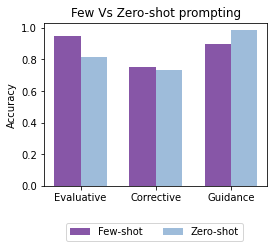

In [195]:
# Example data
categories = ['Evaluative', 'Corrective', 'Guidance']
few_means = [evaluative_few_precision_mean, corrective_few_precision_mean, guidance_few_precision_mean]  # Means for Model 1 in each category
zero_means = [evaluative_zero_precision_mean,corrective_zero_precision_mean, guidance_zero_precision_mean]  # Means for Model 2 in each category
few_std = [evaluative_few_precision_std, corrective_few_precision_std, guidance_few_precision_std]  # Standard deviations for Model 1
zero_std = [evaluative_zero_precision_std, corrective_zero_precision_std, guidance_zero_precision_std]  # Standard deviations for Model 2

# Create figure and axis
fig, ax = plt.subplots(figsize=(4, 3))


# Setting the positions and width for the bars
pos = np.arange(len(categories))
bar_width = 0.35  # Width of bars

# Plotting the bars for each model with error bars
bars1 = ax.bar(pos - bar_width/2, few_means, bar_width, color=(0.53, 0.337, 0.655, 1))
bars2 = ax.bar(pos + bar_width/2, zero_means, bar_width, color=(0.62, 0.737, 0.855, 1))

labels = ["Few-shot", "Zero-shot"]

fig.legend(labels=labels,   # The labels for each line
           borderaxespad=1,    # Small spacing around legend box
           ncol=2, # Title for the legend
           fancybox=True,
           bbox_to_anchor=(0.85, 0),
           bbox_transform=fig.transFigure
           )

ax.set_title('Few Vs Zero-shot prompting')
ax.set_ylabel('Accuracy')
ax.set_xticks(pos)
ax.set_xticklabels(categories)
#ax.legend()

# Show the plot
plt.show()
fig.savefig("fewVSzero.pdf",bbox_inches='tight')

### Prompt rewording

In [129]:
prompt = ("In a discrete Markov Decision Process (MDP) framework simulating a grid-like environment, you are tasked with guiding an agent. This agent's objective is to navigate through the grid to pick up and place a cube at a designated spot."
          "The agent is equipped with a predefined set of actions: "
          "Available Actions: The agent can execute the following moves - move up (action 0), move down (action 1), move left (action 2), move right (action 3), pick up the cube (action 4), and place the cube down (action 5)."
          "Your role involves translating natural language feedback related to the agent's previous actions into a structured format, encompassing evaluative feedback, corrective feedback, and suggestions for future actions. It's important to take into account the feedback's current context as well as any pertinent feedback from past actions."
          "Structure your analysis as follows:"
          "Evaluative: Rate the feedback sentiment numerically: +1 for positive feedback (signifying the action was appropriate or correct), -1 for negative feedback (indicating the action was inappropriate or incorrect), and 0 for neutral feedback or if there's no clear evaluative feedback."
          "Corrective: If a previous action was mistaken, identify the correct action that should have been executed, using the action numbers (0, 1, 2, 3, 4, 5). This feedback should only relate to the prior action. If the feedback's sentiment is positive or neutral, or it doesn't suggest an alternate action, label the corrective feedback as None."
          "Advice: Suggest the next step the agent should take, selecting from the action options (0, 1, 2, 3, 4, 5). If the feedback doesn't suggest a specific next action or focuses only on rectifying a past error without recommending a subsequent step, indicate the advice as None."
          "Your response should be formatted as: 'Evaluative={value} \n Corrective={value} \n Advice={value}'"
          "Example:"\
          "Given Feedback: ""Action=0, No, turn left  """\
          "Evaluative=-1 \n Corrective=None (no correction for past action) \n Advice=2" \
          "Given Feedback: ""Action=1, Now go up """\
          "Evaluative=0 \n Corrective=None \n Advice=0"\
          "Given Feedback: ""Action=0, yes ,turn left"""\
          "Evaluative=1 \n Corrective=None \n Advice=2"\
          "Given Feedback: ""Action=0, No, you should have turned left"""\
          "Evaluative=-1 \n Corrective=2 \n Advice=None (no advice for next action is given)"\
          "Given Feedback: ""Action=4, Yeah!"""\
          "Evaluative=1 \n Corrective=0 \n Advice=None (no advice for next action is given)"\
          "Given Feedback: ""Action=1, Continue like this!"""\
          "Evaluative=1 \n Corrective=0 \n Advice=1 (same as previous action)")


In [130]:
evaluative_estim, corrective_estim, guidance_estim = interpret_examples(client, df['instance']) 

evaluative_reworded_precision_0 = np.where(df['evaluative'].astype(str) == evaluative_estim, 1, 0)
corrective_reworded_precision_0 = np.where(df['corrective'].astype(str) == corrective_estim, 1, 0)
guidance_reworded_precision_0 = np.where(df['guidance'].astype(str) == guidance_estim, 1, 0)


In [131]:
evaluative_estim, corrective_estim, guidance_estim = interpret_examples(client, df['instance']) 

evaluative_reworded_precision_1 = np.where(df['evaluative'].astype(str) == evaluative_estim, 1, 0)
corrective_reworded_precision_1 = np.where(df['corrective'].astype(str) == corrective_estim, 1, 0)
guidance_reworded_precision_1 = np.where(df['guidance'].astype(str) == guidance_estim, 1, 0)


In [132]:
evaluative_estim, corrective_estim, guidance_estim = interpret_examples(client, df['instance']) 

evaluative_reworded_precision_2 = np.where(df['evaluative'].astype(str) == evaluative_estim, 1, 0)
corrective_reworded_precision_2 = np.where(df['corrective'].astype(str) == corrective_estim, 1, 0)
guidance_reworded_precision_2 = np.where(df['guidance'].astype(str) == guidance_estim, 1, 0)


In [133]:
evaluative_reworded_precision = (evaluative_reworded_precision_0 + evaluative_reworded_precision_1 + evaluative_reworded_precision_2) / 3
evaluative_reworded_precision_mean = evaluative_reworded_precision.mean()
evaluative_reworded_precision_std = evaluative_reworded_precision.std()

In [134]:
corrective_reworded_precision = (corrective_reworded_precision_0 + corrective_reworded_precision_1 + corrective_reworded_precision_2) / 3
corrective_reworded_precision_mean = corrective_reworded_precision.mean()
corrective_reworded_precision_std = corrective_reworded_precision.std()

In [135]:
guidance_reworded_precision = (guidance_reworded_precision_0 + guidance_reworded_precision_1 + guidance_reworded_precision_2) / 3
guidance_reworded_precision_mean = guidance_reworded_precision.mean()
guidance_reworded_precision_std = guidance_reworded_precision.std()

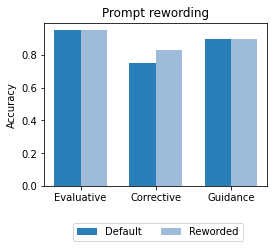

In [197]:
categories = ['Evaluative', 'Corrective', 'Guidance']
few_means = [evaluative_few_precision_mean, corrective_few_precision_mean, guidance_few_precision_mean]  # Means for Model 1 in each category
reworded_means = [evaluative_reworded_precision_mean,corrective_reworded_precision_mean, guidance_reworded_precision_mean]  # Means for Model 2 in each category
# few_std = [evaluative_few_precision_std, corrective_few_precision_std, guidance_few_precision_std]  # Standard deviations for Model 1
# reworded_std = [evaluative_reworded_precision_std, corrective_reworded_precision_std, guidance_reworded_precision_std]  # Standard deviations for Model 2

# Create figure and axis
fig, ax = plt.subplots(figsize=(4, 3))


# Setting the positions and width for the bars
pos = np.arange(len(categories))
bar_width = 0.35  # Width of bars

# Plotting the bars for each model with error bars
bars1 = ax.bar(pos - bar_width/2, few_means, bar_width, color=(0.17, 0.498, 0.72, 1))
bars2 = ax.bar(pos + bar_width/2, reworded_means, bar_width, color=(0.62, 0.737, 0.855, 1))

labels = ["Default", "Reworded"]

fig.legend(labels=labels,   # The labels for each line
           borderaxespad=1,    # Small spacing around legend box
           ncol=2, # Title for the legend
           fancybox=True,
           bbox_to_anchor=(0.85, 0),
           bbox_transform=fig.transFigure
           )

ax.set_title('Prompt rewording')
ax.set_ylabel('Accuracy')
ax.set_xticks(pos)
ax.set_xticklabels(categories)
#ax.legend()

# Show the plot
plt.show()
fig.savefig("rewording.pdf",bbox_inches='tight')

### Different languages

In [138]:
prompt = ("You are working with a discrete Markov Decision Process (MDP) environment that simulates a gridworld. The agent navigates this grid to pick a cube and place it in a specific location. The agent has a set of actions available: \\"
          "Action Space: The agent can move up (action 0), down (action 1), left (action 2), or right (action 3), pick up the cube (action 4), and put down the cube (action 5).)"
          "Your task is to interpret natural language feedback given in response to the agent's past actions, converting this feedback into a structured format for each variable: evaluative feedback, corrective feedback, and advice for future actions. It's crucial to consider both the current feedback and any relevant past feedback when making your interpretations."
          "Here’s how to structure your responses:"
          "Evaluative: Assign a numerical value based on the sentiment of the feedback:) +1 for positive feedback (indicating the action was good or correct). -1 for negative feedback (indicating the action was bad or incorrect). 0 if the feedback is neutral or if no explicit evaluative feedback is given."
           "Corrective: If the past action was incorrect, specify the action that should have been taken instead, choosing from the defined action space (0, 1, 2, 3, 4, 5). This feedback is focused on the past action only. If the sentiment of the feedback is correct or neutral, or no alternative action is implied, corrective feedback should be None. "
          "Advice: Provide a suggestion for the next action the agent should take by assiging the correspondant value from the action space choosing from the defined action space (0, 1, 2, 3, 4, 5) . If the feedback does not imply a specific next action or is focused solely on correcting a past mistake without suggesting a next move, Advice should be None."
          "The output should follow the following format: 'Evaluative={value} \n Corrective={value} \n Advice={value}'" 
          "Example:"\
          "Given Feedback: ""Action=0, No, turn left  """\
          "Evaluative=-1 \n Corrective=None (no correction for past action) \n Advice=2" \
          "Given Feedback: ""Action=1, Now go up """\
          "Evaluative=0 \n Corrective=None \n Advice=0"\
          "Given Feedback: ""Action=0, yes ,turn left"""\
          "Evaluative=1 \n Corrective=None \n Advice=2"\
          "Given Feedback: ""Action=0, No, you should have turned left"""\
          "Evaluative=-1 \n Corrective=2 \n Advice=None (no advice for next action is given)"\
          "Given Feedback: ""Action=4, Yeah!"""\
          "Evaluative=1 \n Corrective=0 \n Advice=None (no advice for next action is given)"\
          "Given Feedback: ""Action=1, Continue like this!"""\
          "Evaluative=1 \n Corrective=0 \n Advice=1 (same as previous action)")


#### French

In [139]:
df = pd.read_excel('datasets/examples_french.xlsx')

In [140]:
evaluative_estim, corrective_estim, guidance_estim = interpret_examples(client, df['instance']) 

evaluative_french_precision = np.where(df['evaluative'].astype(str) == evaluative_estim, 1, 0)
corrective_french_precision = np.where(df['corrective'].astype(str) == corrective_estim, 1, 0)
guidance_french_precision = np.where(df['guidance'].astype(str) == guidance_estim, 1, 0)


#### Arabic

In [145]:
df = pd.read_excel('datasets/examples_arabic.xlsx')

In [146]:
evaluative_estim, corrective_estim, guidance_estim = interpret_examples(client, df['instance']) 

evaluative_arabic_precision = np.where(df['evaluative'].astype(str) == evaluative_estim, 1, 0)
corrective_arabic_precision = np.where(df['corrective'].astype(str) == corrective_estim, 1, 0)
guidance_arabic_precision = np.where(df['guidance'].astype(str) == guidance_estim, 1, 0)


#### Italian

In [157]:
df = pd.read_excel('datasets/examples_italian.xlsx')

In [158]:
evaluative_estim, corrective_estim, guidance_estim = interpret_examples(client, df['instance']) 

evaluative_italian_precision = np.where(df['evaluative'].astype(str) == evaluative_estim, 1, 0)
corrective_italian_precision = np.where(df['corrective'].astype(str) == corrective_estim, 1, 0)
guidance_italian_precision = np.where(df['guidance'].astype(str) == guidance_estim, 1, 0)

#### Spanish

In [160]:
df = pd.read_excel('datasets/examples_spanish.xlsx')

In [161]:
evaluative_estim, corrective_estim, guidance_estim = interpret_examples(client, df['instance']) 

evaluative_spanish_precision = np.where(df['evaluative'].astype(str) == evaluative_estim, 1, 0)
corrective_spanish_precision = np.where(df['corrective'].astype(str) == corrective_estim, 1, 0)
guidance_spanish_precision = np.where(df['guidance'].astype(str) == guidance_estim, 1, 0)

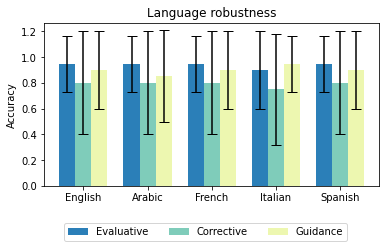

In [199]:

languages = ['English', 'Arabic', 'French', 'Italian', 'Spanish']
evaluative_means = [evaluative_few_precision_0.mean(), evaluative_arabic_precision.mean(), evaluative_french_precision.mean(), evaluative_italian_precision.mean(), evaluative_spanish_precision.mean()]  # Evaluative means for each language
corrective_means = [corrective_few_precision_0.mean(), corrective_arabic_precision.mean(), corrective_french_precision.mean(), corrective_italian_precision.mean(), corrective_spanish_precision.mean()]  # corrective means for each language
guidance_means = [guidance_few_precision_0.mean(), guidance_arabic_precision.mean(), guidance_french_precision.mean(), guidance_italian_precision.mean(), guidance_spanish_precision.mean()]  # guidance means for each language

# Standard deviations for each category (for demonstration)
evaluative_stds = [evaluative_few_precision_0.std(), evaluative_arabic_precision.std(), evaluative_french_precision.std(), evaluative_italian_precision.std(), evaluative_spanish_precision.std()]  # Evaluative stds for each language
corrective_stds = [corrective_few_precision_0.std(), corrective_arabic_precision.std(), corrective_french_precision.std(), corrective_italian_precision.std(), corrective_spanish_precision.std()]  # corrective stds for each language
guidance_stds = [guidance_few_precision_0.std(), guidance_arabic_precision.std(), guidance_french_precision.std(), guidance_italian_precision.std(), guidance_spanish_precision.std()]  # guidance stds for each language


# Setting up the figure and axes
fig, ax = plt.subplots(figsize=(6, 3))

# Setting the positions and width for the bars
bar_width = 0.25  # Width of bars
# Calculating the positions for the groups
index = np.arange(len(languages))

# Plotting the bars for each evaluation type
bars1 = ax.bar(index - bar_width, evaluative_means, bar_width, yerr=evaluative_stds,
               capsize=5, label='Evaluative', color=(0.17, 0.498, 0.72, 1))
bars2 = ax.bar(index, corrective_means, bar_width, yerr=corrective_stds,
               capsize=5, label='Corrective', color=(0.498, 0.8, 0.73, 1))
bars3 = ax.bar(index + bar_width, guidance_means, bar_width, yerr=guidance_stds,
               capsize=5, label='Guidance', color=(0.93, 0.97, 0.69, 1))

# Adding some final touches
ax.set_ylabel('Accuracy')
ax.set_title('Language robustness')
ax.set_xticks(index)
ax.set_xticklabels(languages)
#ax.legend()

labels = ["Evaluative", "Corrective", "Guidance"]

fig.legend(labels=labels,   # The labels for each line
           borderaxespad=1,    # Small spacing around legend box
           ncol=3, # Title for the legend
           fancybox=True,
           bbox_to_anchor=(0.85, 0),
           bbox_transform=fig.transFigure
           )

# Show the plot
plt.show()
fig.savefig("language.pdf",bbox_inches='tight')